# Intro to this package, Part 1
---

Here we introduce the functionalities of our package and the dynamical models it uses.

## 0. Setup
---
Uncomment the following line to install `rl4greencrab`. 
After installation you need to restart the jupyter kernel in order to use the package and run this notebook.

In [1]:
# %pip install -e ..

In [2]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_density, geom_line, geom_point, 
    geom_violin, facet_grid, labs, theme, facet_wrap,
)

## 1. Green crab population dynamics environment
---

We model the dynamics of an invasive crab population at one site (e.g. a bay or estuary) using a size-resolved model with 21 size classes.
This dynamics is encapsulated into an environment class `greenCrabEnv`.
Let's declare the env and initialize it using the `.reset()` function.

In [3]:
from rl4greencrab import greenCrabEnv
from rl4greencrab import simulator, constAction, multiConstAction, constActionNatUnits

gce = greenCrabEnv()
gce.reset()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), {})

As the name implies, this resets the state of the env to some initial value. 
Additionally, it returns two outputs: the first is an *observation* (whose meaning we will cover in the next section) and the second is an *information dict*.
This type of information dicts can be useful for debugging and generally logging detailed information about the env's state.
We will ignore information dicts throughout this tutorial.

## 2. Dynamics
---

The dynamics of the system all occur within the `.step()` function.
This function evolves the state of the system one time-step, which in our model corresponds to one year.
The `.step()` function requires one argument, an *action*, which is the number of crab traps set in that bay throughout the year.
Actions can currently take values between 0 and 2000:

In [4]:
gce.action_space

Box(0.0, 2000.0, (3,), float32)

The attribue `gce.action_space` is of the type `gymnasium.spaces.Box`, a standard class used for action spaces in the RL world.

Let's try and calling the step function to see what comes out.

In [5]:
gce.step(np.array([0,0,0]))

(array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 -0.00013082078076842287,
 False,
 False,
 {})

The output here is:

`observation`, `reward`, `terminated`, `truncated`, `info`

We won't go into the last three outputs here as they are irrelevant for this notebook.
Here, I want to focus on the `observation` and the `reward` outputs.

`observation` is a sequence of nine numbers, in this case they are all zero.
These numbers correspond to crab catch counts for each of nine months in the year (we do not produce count data in the gestation period of the year, which is three months long).
The reason they are all zero is that we laid zero traps this time-step.
For example, let's look at the observations resulting from different numbers of traps:

In [6]:
(
    list(gce.step(np.array([10,10,10]))[0]), 
    list(gce.step(np.array([100,100,100]))[0]), 
    list(gce.step(np.array([1000,1000,1000]))[0]),
)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 4.0],
 [22.0, 22.0, 35.0, 23.0, 22.0, 30.0, 39.0, 50.0, 36.0])

Notice that for high numbers of traps---in the case above in the case where 1000 traps are laid---, we can see a decrease in catch counts as the year progresses.
This is due to the diminishing population as a consequence of the traps laid.

### Rewards

The `reward` output is computed by balancing out two simultaneous goals of the agent: 1. to minimize the environmental damage produced by the invasive green crab population, and, 2. to minimize the cost of laying traps and removing trapped crabs.
We will examine the reward function in more detail later in this notebook.

### Structure of the decision problem

This is the structure of the decision problem defined by `greenCrabenv`:
The agent observes green crab catch counts each month for 9 months and then, based on that data, the agent chooses the number of traps to lay next year.
The cycle then repeats, and it repeats for an *episode* of 100 time-steps.
The goal of the agent is to choose a policy that maximizes the average reward it receives over an episode.
Because of how we've set up our reward function, this policy will balance the need to keep the invasive population in check with the cost of doing so.

## 3. Crab size distribution
---

As mentioned, our model describes the size distribution of crabs using 21 size classes. 
At any point in the dynamics, this ''internal'' state of the environment is stored as `gce.state`.
Let's plot how this size distribution evolves over time when subjected to different numbers of traps.

/tmp/ipykernel_5546/3463681099.py:8: RuntimeWarning: invalid value encountered in divide
/opt/venv/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 21 rows containing missing values.


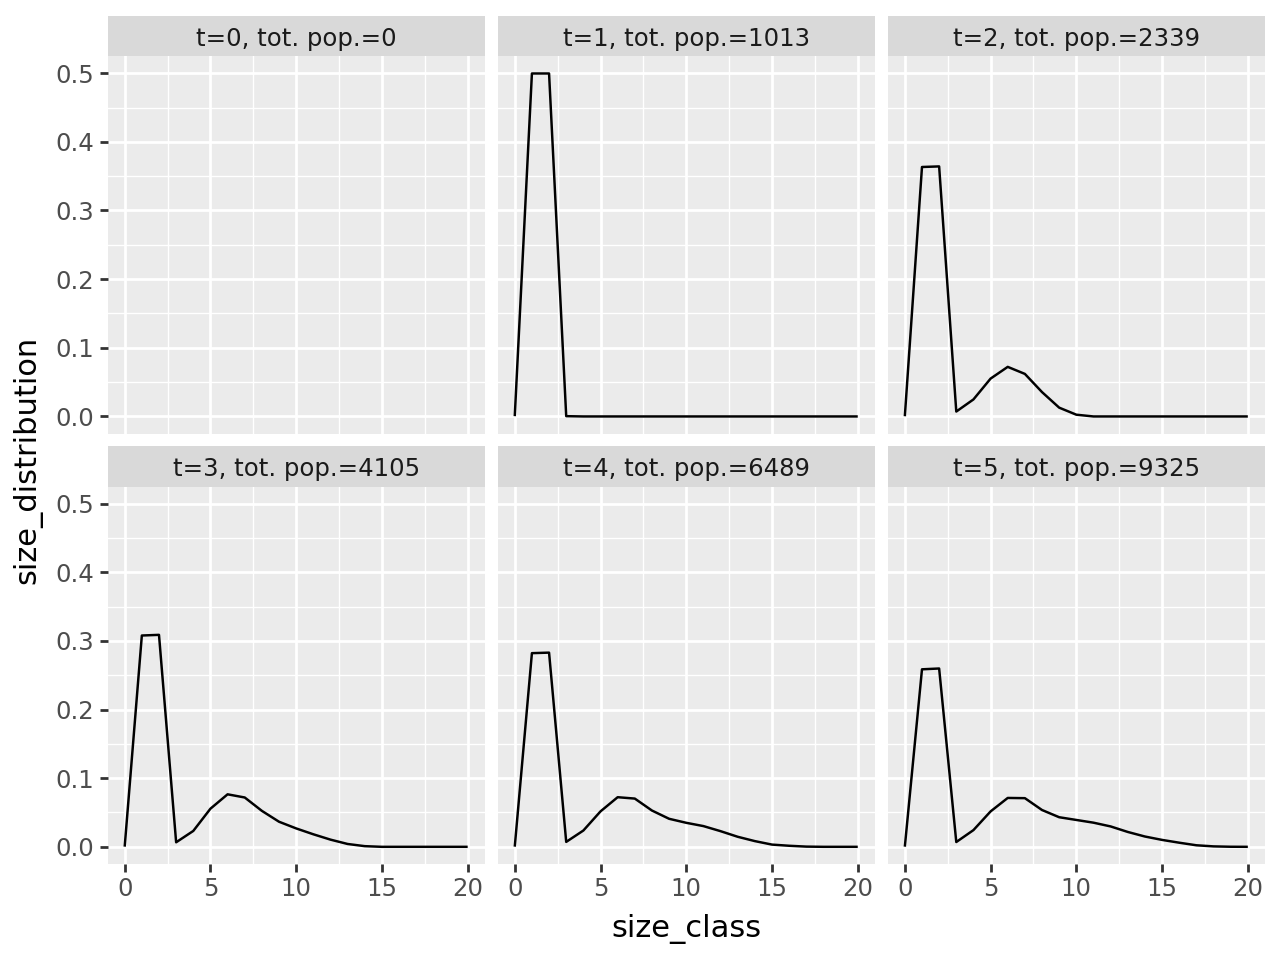

In [7]:
gce.reset()

size_dist = pd.DataFrame()

for t in range(6):
    new_size_dist = pd.DataFrame(
        {
            'size_distribution': gce.state / sum(gce.state),
            'size_class': list(range(21)),
            'label': 21*[f"t={t}, tot. pop.={int(sum(gce.state))}"],
        }
    )
    size_dist = pd.concat(
        [size_dist, new_size_dist],
        ignore_index=True,
    )
    gce.step(np.array([0,0,0]))
(
    ggplot(size_dist, aes(x='size_class',y='size_distribution')) 
    + geom_line() 
    + facet_wrap(facets='label',) 
    # + labs(title=f"N. traps = 0, final pop = {sum(gce.state):.0f}")
    + theme(aspect_ratio=1)
)



Here we see that the relative distribution of sizes converges to a bimodal shape, and that the total crab population increases over time. 
If we were to run this simulation further, we would see the total crab population saturating at around its carrying capacity of 25 000.

### Crab size distribution with traps

Let's try the same code above but laying out a non-zero number of traps.

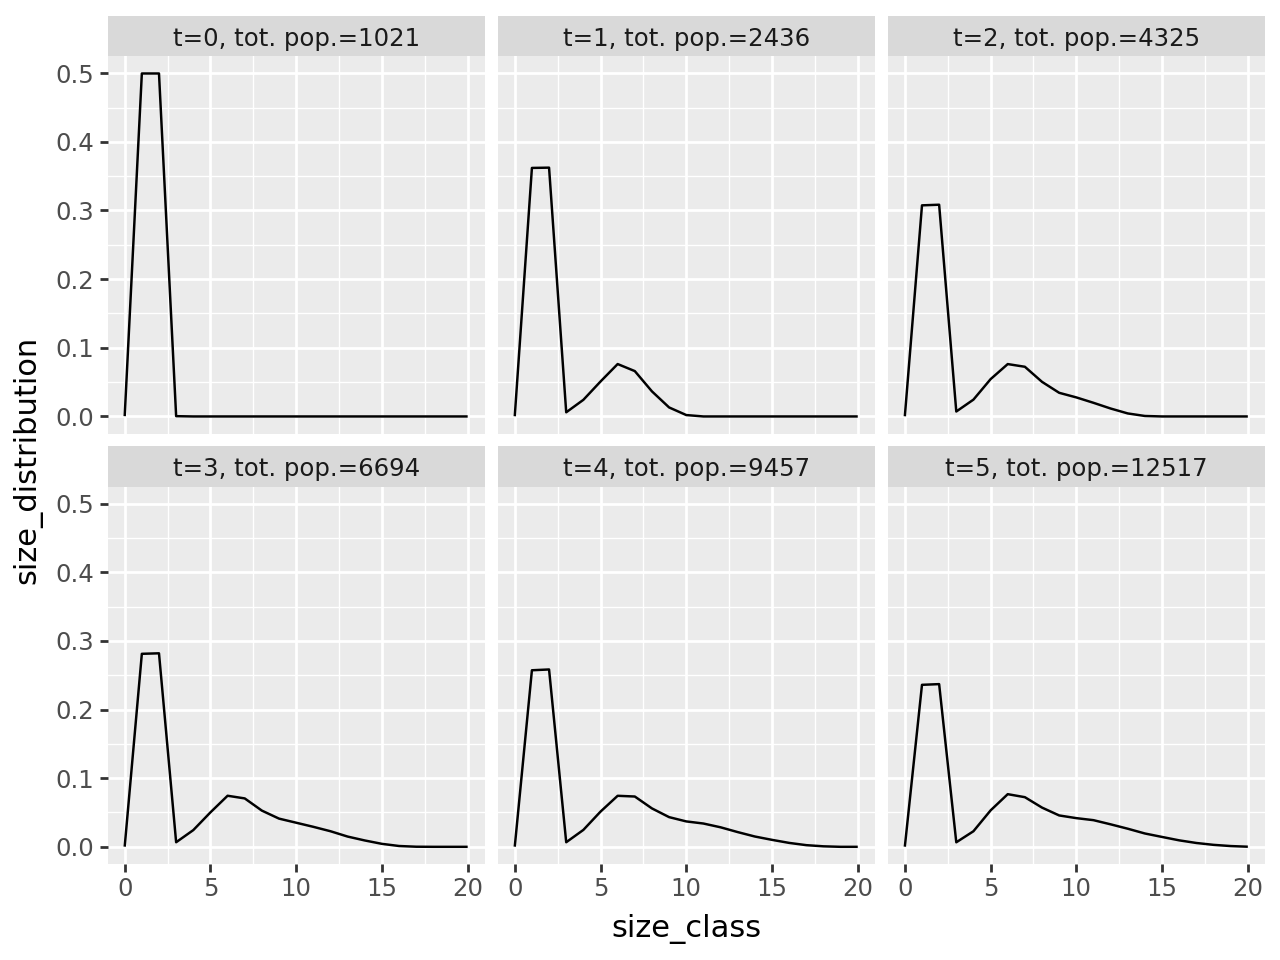

In [8]:
n_traps = 100
gce.reset()
size_dist = pd.DataFrame()

for t in range(6):
    gce.step(np.array([n_traps, n_traps, n_traps]))
    new_size_dist = pd.DataFrame(
        {
            'size_distribution': gce.state / sum(gce.state),
            'size_class': list(range(21)),
            'label': 21*[f"t={t}, tot. pop.={int(sum(gce.state))}"],
        }
    )
    size_dist = pd.concat(
        [size_dist, new_size_dist],
        ignore_index=True,
    )
(
    ggplot(size_dist, aes(x='size_class',y='size_distribution')) 
    + geom_line() 
    + facet_wrap(facets='label',) 
    # + labs(title=f"N. traps = 0, final pop = {sum(gce.state):.0f}")
    + theme(aspect_ratio=1)
)



Here we notice two things:
First, as expected, the population growth is limited by the traps, and seems to saturate around the 4 000 mark.
Second. the *relative* size distribution converges to a a different shape in this case too.

This second point reveals a property of our model: the traps are size selective!
In fact, the traps included in this initial model of `greenCrabEnv`, are good at catching middle-sized crabs, but bad at catching large or small crabs.
In the near future we will include more models in this package that allow for the agent to choose between different trap types.

## 4. Tuning constant action agents

The simplest type of strategy for this management problem would be a non-adaptive one: a fixed number of traps are laid out at the beginning of the episode and they catch crabs for the entire episode.
We now tune this strategy by finding the number of traps that obtains the best reward value.

In [9]:
from rl4greencrab import evaluate_agent

def evaluateConstAct(x):
    config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,
        'action_reward_exponent': 10,
    }
    env = greenCrabEnv(config=config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    return - m_reward

### Optimization

We'll try two methods from the `scikit-optimize` package to tune our constant action strategy.

In [10]:
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective

In [ ]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.


2024-05-10 23:31:13,825	INFO worker.py:1724 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.6797
Function value obtained: 2.2624
Current minimum: 2.2624
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8757
Function value obtained: 33.1245
Current minimum: 2.2624
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.4399
Function value obtained: 4.8922
Current minimum: 2.2624
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5205
Function value obtained: 0.4092
Current minimum: 0.4092
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.5620
Function value obtained: 7.2181
Current minimum: 0.4092
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation 

(raylet) [2024-05-10 23:32:13,958 E 5968 5968] (raylet) node_manager.cc:3024: 56 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 874e83ccb97b25ab2abc0ed1df3c56e98ff6fd906d0cea71ec1d05b6, IP: 10.42.0.86) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.42.0.86`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.9870
Function value obtained: 0.3729
Current minimum: 0.3729
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.9500
Function value obtained: 0.6044
Current minimum: 0.3729
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 2.0741
Function value obtained: 0.4384
Current minimum: 0.3729
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.9168
Function value obtained: 0.4333
Current minimum: 0.3729
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.0045
Function value obtained: 0.4264
Current minimum: 0.3729
Iteration No: 42 started. Sea

(raylet) [2024-05-10 23:33:13,960 E 5968 5968] (raylet) node_manager.cc:3024: 58 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 874e83ccb97b25ab2abc0ed1df3c56e98ff6fd906d0cea71ec1d05b6, IP: 10.42.0.86) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.42.0.86`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 2.0080
Function value obtained: 0.3638
Current minimum: 0.3492
Iteration No: 67 started. Searching for the next optimal point.
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 1.9652
Function value obtained: 0.3934
Current minimum: 0.3492
Iteration No: 68 started. Searching for the next optimal point.
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 2.1506
Function value obtained: 0.3492
Current minimum: 0.3492
Iteration No: 69 started. Searching for the next optimal point.
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 2.0197
Function value obtained: 0.3491
Current minimum: 0.3491
Iteration No: 70 started. Searching for the next optimal point.
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 4.6402
Function value obtained: 0.3555
Current minimum: 0.3491
Iteration No: 71 started. Sea

(raylet) [2024-05-10 23:34:13,962 E 5968 5968] (raylet) node_manager.cc:3024: 58 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 874e83ccb97b25ab2abc0ed1df3c56e98ff6fd906d0cea71ec1d05b6, IP: 10.42.0.86) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.42.0.86`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.9887
Function value obtained: 0.3458
Current minimum: 0.3411
Iteration No: 92 started. Searching for the next optimal point.
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 2.2898
Function value obtained: 0.3482
Current minimum: 0.3411
Iteration No: 93 started. Searching for the next optimal point.
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 2.0150
Function value obtained: 0.3451
Current minimum: 0.3411
Iteration No: 94 started. Searching for the next optimal point.
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 2.2470
Function value obtained: 0.3625
Current minimum: 0.3411
Iteration No: 95 started. Searching for the next optimal point.
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 4.3975
Function value obtained: 0.7258
Current minimum: 0.3411
Iteration No: 96 started. Sea

In [ ]:
import matplotlib.pyplot as plt
plt.close()
plot_objective(res)
plt.show()

In [ ]:
evaluateConstAct(
    [869.3405896605859, 582.8685243387607, 968.4643115701439]
)

### Fix X2 which seems very well defined, and vary X0 and X1

In [25]:
def evaluateConstAct_not_x2(x):
    config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,
        'action_reward_exponent': 10,
    }
    env = greenCrabEnv(config=config)
    agent = multiConstAction(env=env, action=np.array([*x, 1530.8775860138805]))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    return - m_reward

In [26]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct_not_x2, 2*[(0.0, max_action)], n_calls = 80, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4587
Function value obtained: 0.4027
Current minimum: 0.4027
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4375
Function value obtained: 0.4913
Current minimum: 0.4027
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4281
Function value obtained: 0.4170
Current minimum: 0.4027
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4252
Function value obtained: 6.4085
Current minimum: 0.4027
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4179
Function value obtained: 0.3453
Current minimum: 0.3453
Iteration No: 6 started. Evaluating

[1495.3216685889224, 1271.0932590848786]

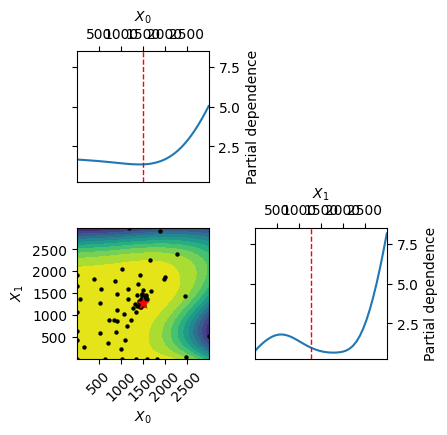

In [27]:
import matplotlib.pyplot as plt
plt.close()
plot_objective(res)
plt.show()

### GBRT

In [ ]:
%%time
res = gbrt_minimize(evaluateConstAct, [(0.0, 2000.)], n_calls = 120)
res.x

In [ ]:
plot_convergence(res)
plt.show()

# validate by looking:

In [19]:
def evaluateConstAct_v2(x, env, trap_type):
    agent = constAction(env=env, action=x, trap_type=trap_type)
    rewards = simulator(env, agent).simulate(reps=50)
    out = np.mean(rewards)
    return - out

In [20]:
from rl4greencrab.utils.simulate import get_simulator
import ray

max_action = 8000
ntrap_choices = list(range(0, max_action+1, max_action//100)) #start, stop, step
CONFIG = {
    'action_reward_scale': np.array([0.001, 0.001, 0.1]),
    'max_action': max_action,
    'env_Stoch': 0.,
}
trap_type = 1

sim = get_simulator(ray_remote=True)
def evaluate_v3(env, agent, reps=50):
    return - np.mean(ray.get([sim.remote(env, agent) for _ in range(reps)]))
    
rewards = [
    evaluate_v3(
        env=greenCrabEnv(config=CONFIG),
        agent=constAction(
            env=greenCrabEnv(config=CONFIG), 
            action=action, 
            trap_type=trap_type,
        )
    )
    for action in ntrap_choices
]

df = pd.DataFrame(
    {
        'rew': rewards,
        'ntraps': ntrap_choices,
    }
)
df.plot(x='ntraps')

2024-04-17 21:32:49,032	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::simulator() (pid=866173, ip=10.42.0.121)
  File "/home/rstudio/boettiger-lab/rl4greencrab/src/rl4greencrab/utils/simulate.py", line 39, in simulator
    observation, reward, terminated, done, info = env.step(action)
  File "/home/rstudio/boettiger-lab/rl4greencrab/src/rl4greencrab/envs/green_crab_ipm.py", line 122, in step
    + self.size_sel_log(self.trapf_pmax, self.trapf_midpoint, self.trapf_k)*action[1]
IndexError: index 1 is out of bounds for axis 0 with size 1
2024-04-17 21:32:49,034	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::simulator() (pid=866044, ip=10.42.0.121)
  File "/home/rstudio/boettiger-lab/rl4greencrab/src/rl4greencrab/utils/simulate.py", line 39, in simulator
    observation, reward, terminated, done, info = env.step(action)
  File "/home/rstudio/boettiger-lab/rl4greencrab/src/rl4greencrab/envs/green_cr

<Axes: xlabel='ntraps'>

In [21]:
evaluateConstAct([0]), evaluateConstAct([100]), evaluateConstAct([356]), evaluateConstAct([1000])

RayTaskError(IndexError): [36mray::simulator()[39m (pid=866071, ip=10.42.0.121)
  File "/home/rstudio/boettiger-lab/rl4greencrab/src/rl4greencrab/utils/simulate.py", line 39, in simulator
    observation, reward, terminated, done, info = env.step(action)
  File "/home/rstudio/boettiger-lab/rl4greencrab/src/rl4greencrab/envs/green_crab_ipm.py", line 122, in step
    + self.size_sel_log(self.trapf_pmax, self.trapf_midpoint, self.trapf_k)*action[1]
IndexError: index 1 is out of bounds for axis 0 with size 1